In [1]:
# nvidia-smi
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [17]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import multiprocessing
import time
import warnings
import copy

from tqdm import tqdm
from torch import nn, Tensor
from torch.nn import Sequential as Seq, Linear, Parameter, ReLU
from torch_scatter import scatter
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, GCNConv, GATConv
from torch_geometric.utils import add_self_loops, degree
# from utils.preprocessing_for_contour import create_data
from utils.preprocessing_for_bezier import create_data

In [18]:
# load image file paths
svg_folder = './datasets/svg'
imgs = []
dataset = []

for root, folders, files in os.walk(svg_folder):
    for file in files:
        if file.split('.')[1] != 'svg': continue
        if 'checkpoint' in file: continue
        
        file_path = os.path.join(svg_folder, file)
        imgs.append(file_path)

In [19]:
# for i, file_path in enumerate(tqdm(imgs)):
    # try:
    #     dataset.append(create_data(file_path))
    # except:
    #     print(file_path) 
    #     raise SystemExit
    
dataset = []

# file_path = "./datasets/svg/011-library.svg"
# data = create_data(file_path)
# dataset.append(data)

##################################################################

file_path = "./datasets/svg/053-weather.svg"
data = create_data(file_path)
dataset.append(data)

file_path = "./datasets/svg/063-rain-3.svg"
data = create_data(file_path)
dataset.append(data)

file_path = "./datasets/svg/010-thunderstorm-20230124.svg"
data = create_data(file_path)
dataset.append(data)

file_path = "./datasets/svg/038-cloudy-3.svg"
data = create_data(file_path)
dataset.append(data)

file_path = "./datasets/svg/034-cloudy-1.svg"
data = create_data(file_path)
dataset.append(data)

file_path = "./datasets/svg/024-cloud.svg"
data = create_data(file_path)
dataset.append(data)

file_path = "./datasets/svg/004-cloudy day.svg"
data = create_data(file_path)
dataset.append(data)

file_path = "./datasets/svg/001-cloudy-5-230122.svg"
data = create_data(file_path)
dataset.append(data)

file_path = "./datasets/svg/cloud-computing-23-230122.svg"
data = create_data(file_path)
dataset.append(data)

file_path = "./datasets/svg/cloud-230123-1.svg"
data = create_data(file_path)
dataset.append(data)

file_path = "./datasets/svg/103-heart-7.svg"
data = create_data(file_path)
dataset.append(data)

##################################################################

file_path = "./datasets/svg/011-cloudy.svg"
data = create_data(file_path)
dataset.append(data)

file_path = "./datasets/svg/085-heart.svg"
data = create_data(file_path)
dataset.append(data)

torch.manual_seed(16)
np.random.seed(16)

batch_size = 1
train_loader = DataLoader(dataset[:11], batch_size=batch_size)
val_loader = DataLoader(dataset[11:], batch_size=batch_size)

print(len(dataset))
print(len(train_loader), len(val_loader))

13
11 2


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
# # hyperparameters
# torch.manual_seed(16)

# batch_size = 1
# num_features = 5
# num_output = 3
# num_epoch = 100

# _train = int(len(dataset) * 0.95)
# _val = _train + int(len(dataset) * 0.03)
# _test = len(dataset) - _val

# # create dataloader
# train_set, val_set, test_set = dataset[:_train], dataset[_train:_val], dataset[_val:]
# train_svg, val_svg, test_svg = imgs[:_train], imgs[_train:_val], imgs[_val:]

# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# print(f"Training Data: {len(train_set)}\nValidation Data: {len(val_set)}\nTesting Data: {len(test_set)}")

#### original GCNConv

In [22]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = GCNConv(5, 16, improved=True)
#         self.conv2 = GCNConv(16, 64, improved=True)
#         self.fc1 = nn.Linear(64, 16)
#         self.fc2 = nn.Linear(16, 3)
        
#     def forward(self, data):
#         x, edge_index = copy.deepcopy(data.x), data.edge_index
        
#         # # normalization -1~1
#         # num = int(data.cluster[-1]) + 1
#         # start = 0
#         # for i in range(num):
#         #     points = x[data.cluster==i]
#         #     cnt = len(points)
#         #     mean = torch.mean(points, dim=0)[3:]
#         #     std = torch.std(points, dim=0)[3:]
#         #     x[start:start+cnt,3:] = (x[start:start+cnt,3:] - mean) / std
#         #     start = start + cnt
        
#         # normalization 0-1
#         num = int(data.cluster[-1]) + 1
#         start = 0
#         for i in range(num):
#             points = x[data.cluster==i]
#             cnt = len(points)
#             _min, _max = torch.min(x[:,3:], dim=0).values, torch.max(x[:,3:], dim=0).values
#             x[start:start+cnt,3:] = 1 * (x[start:start+cnt,3:] - _min) / (_max - _min)
#             start = start + cnt
        
#         x = self.conv1(x, edge_index)
#         x = self.conv2(x, edge_index)

#         x = scatter(x, data.cluster, dim=0, reduce='mean')
               
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
        
#         return torch.sigmoid(x)

#### in_features=7 and add in-group edge_attr

In [23]:
# class GCN(MessagePassing):
#     def __init__(self, in_channels, out_channels, edge_attr=True, bias=True):
#         super(GCN, self).__init__(aggr='mean')
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.edge_attr = edge_attr
#         self.linear = nn.Linear(in_channels + 4 if edge_attr else in_channels, out_channels, bias=bias)

#     def forward(self, x, edge_index, edge_attr=None):
#         return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, edge_attr=edge_attr)

#     def message(self, x_j, edge_attr):
#         x_j = torch.cat((x_j, edge_attr), dim=1)
#         return x_j
    
#     def update(self, aggr_out, x):
#         return self.linear(aggr_out)

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = GCN(7, 16)
#         self.conv2 = GCN(16, 64)
#         self.fc1 = nn.Linear(64, 16)
#         self.fc2 = nn.Linear(16, 3)
        
#     def forward(self, data):
#         x, edge_index, edge_attr = copy.deepcopy(data.x), data.edge_index, data.edge_attr
#         coords = data.x[:, 3:]
        
#         # normalization 0-1
#         num = int(data.cluster[-1]) + 1
#         start = 0
#         for i in range(num):
#             points = x[data.cluster==i]
#             cnt = len(points)
#             _min, _max = torch.min(x[:,3:], dim=0).values, torch.max(x[:,3:], dim=0).values
#             x[start:start+cnt,3:] = 1 * (x[start:start+cnt,3:] - _min) / (_max - _min)
#             start = start + cnt
            
#         x = torch.concat((x, coords), dim=1)  # in_features=7
        
#         x = self.conv1(x, edge_index, edge_attr)
#         x = self.conv2(x, edge_index, edge_attr)

#         x = scatter(x, data.cluster, dim=0, reduce='mean')
               
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
        
#         return torch.sigmoid(x)

#### add group information

In [24]:
# class GCN(MessagePassing):
#     def __init__(self, in_channels, out_channels, num_edge_attr, edge_attr=True, bias=True):
#         super(GCN, self).__init__(aggr='mean')
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.edge_attr = edge_attr
#         self.linear = nn.Linear(in_channels + num_edge_attr if edge_attr else in_channels, out_channels, bias=bias)

#     def forward(self, x, edge_index, edge_attr=None):
#         return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, edge_attr=edge_attr)

#     def message(self, x_j, edge_attr):
#         x_j = torch.cat((x_j, edge_attr), dim=1)
#         return x_j
    
#     def update(self, aggr_out, x):
#         return self.linear(aggr_out)

# class GraphEncoder(nn.Module):
#     def __init__(self):
#         super(GraphEncoder, self).__init__()
#         self.conv1 = GCN(7, 16, num_edge_attr=4)
#         self.conv2 = GCN(16, 64, num_edge_attr=4)
        
#     def forward(self, data):
#         x, edge_index, edge_attr = copy.deepcopy(data.x), data.edge_index, data.edge_attr
#         coords = data.x[:, 3:]
#         num = int(data.cluster[-1]) + 1
#         start = 0
#         for i in range(num):  # normalization
#             points = x[data.cluster==i]
#             cnt = len(points)
#             _min, _max = torch.min(x[:,3:], dim=0).values, torch.max(x[:,3:], dim=0).values
#             x[start:start+cnt,3:] = (x[start:start+cnt,3:] - _min) / (_max - _min)
#             start = start + cnt
            
#         x = torch.concat((x, coords), dim=1)  # in_features=7
        
#         x = self.conv1(x, edge_index, edge_attr)
#         x = self.conv2(x, edge_index, edge_attr)
#         x = scatter(x, data.cluster, dim=0, reduce='mean')
        
#         return x

# class MLP(nn.Module):
#     def __init__(self, in_features):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(in_features, 16),
#             nn.ReLU(),
#             nn.Linear(16, 3),
#         )
        
#     def forward(self, x):
#         x = self.layers(x)
#         return torch.sigmoid(x)
    
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.encoder = GraphEncoder()
#         # self.group1 = GCN(2, 16)
#         # self.group2 = GCN(16, 64)
#         self.feature1 = GCN(64, 128, num_edge_attr=1)
#         self.feature2 = GCN(128, 64, num_edge_attr=1)
#         self.mlp = None
        
#     def forward(self, data):
#         group_x, group_edge_index, group_edge_attr= copy.deepcopy(data.group_x), data.group_edge_index, data.group_edge_attr
        
#         out = self.encoder(data)  # encode node features

#         if len(group_edge_index) != 0:
            
#             # input the aggregrated node features
#             # and the group_index and group_edge_attr
#             out = self.feature1(out, group_edge_index, group_edge_attr)
#             out = self.feature2(out, group_edge_index, group_edge_attr)
            
#             # # connection between closed curves
#             # _min, _max = torch.min(group_x, dim=0).values, torch.max(group_x, dim=0).values  # normalization
#             # group_x = (group_x - _min) / (_max - _min)
#             # group_x = self.group1(group_x, group_edge_index)
#             # group_x = self.group2(group_x, group_edge_index)

#             # # internal node features
#             # feature = self.feature1(out, group_edge_index)
#             # feature = self.feature2(feature, group_edge_index)
            
#             # out = torch.cat((group_x, feature), dim=1)  # concat position node features

#         self.mlp = MLP(out.shape[-1]).to(device)
#         out = self.mlp(out)
#         return out

---
---

In [25]:
# # # classification
# # class Net(nn.Module):
# #     def __init__(self):
# #         super(Net, self).__init__()
# #         self.conv1 = GCNConv(2, 16, improved=True)
# #         self.conv2 = GCNConv(16, 64, improved=True)
# #         self.fc1 = nn.Linear(64, 16)
# #         self.fc2 = nn.Linear(16, 10)
        
# #     def forward(self, data):
# #         x, edge_index = copy.deepcopy(data.x), data.edge_index
        
# #         # normalization
# #         num = int(data.cluster[-1]) + 1
# #         start = 0
# #         for i in range(num):
# #             points = x[data.cluster==i]
# #             cnt = len(points)
# #             _min, _max = torch.min(points[:,3:], dim=0).values, torch.max(points[:,3:], dim=0).values
# #             x[start:start+cnt,3:] = 16 * (x[start:start+cnt,3:] - _min) / (_max - _min)
# #             start = start + cnt
            
# #         x = x[:,3:]
# #         x = self.conv1(x, edge_index)
# #         x = self.conv2(x, edge_index)

# #         x = scatter(x, data.cluster, dim=0, reduce='mean')
               
# #         x = self.fc1(x)
# #         x = F.relu(x)
# #         x = self.fc2(x)
        
# #         # return x
# #         return F.softmax(x, dim=1)

# ####################################################################
    
# # in-group edge_attr 
# class GCN(MessagePassing):
#     def __init__(self, in_channels, out_channels, edge_attr=True, bias=True):
#         super(GCN, self).__init__(aggr='mean')
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.edge_attr = edge_attr
#         self.linear = nn.Linear(in_channels + 2 if edge_attr else in_channels, out_channels, bias=bias)

#     def forward(self, x, edge_index, edge_attr=None):
#         return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, edge_attr=edge_attr)

#     def message(self, x_j, edge_attr):
#         x_j = torch.cat((x_j, edge_attr), dim=1)
#         return x_j
    
#     def update(self, aggr_out, x):
#         return self.linear(aggr_out)

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = GCN(2, 16)
#         self.conv2 = GCN(16, 64)
#         self.fc1 = nn.Linear(64, 16)
#         self.fc2 = nn.Linear(16, 2)
        
#     def forward(self, data):
#         x, edge_index, edge_attr = copy.deepcopy(data.x), data.edge_index, data.edge_attr
#         coords = data.x[:, 3:]
        
#         num = int(data.cluster[-1]) + 1
#         start = 0
#         for i in range(num):
#             points = x[data.cluster==i]
#             cnt = len(points)
#             _min, _max = torch.min(points[:,3:], dim=0).values, torch.max(points[:,3:], dim=0).values
#             x[start:start+cnt,3:] = 10 * x[start:start+cnt,3:] - _min * 16  # but distance didn't normalize
#             start = start + cnt
            
#         x = x[:,3:]
#         x = self.conv1(x, edge_index, edge_attr)
#         x = self.conv2(x, edge_index, edge_attr)
#         x = scatter(x, data.cluster, dim=0, reduce='mean')
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
        
#         return torch.sigmoid(x)
    
    
# ####################################################################
    
# # # regression
# # class Net(nn.Module):
# #     def __init__(self):
# #         super(Net, self).__init__()
# #         self.conv1 = GCNConv(2, 16, improved=True)
# #         self.conv2 = GCNConv(16, 64, improved=True)
# #         self.fc1 = nn.Linear(64, 16)
# #         self.fc2 = nn.Linear(16, 2)
        
# #     def forward(self, data):
# #         x, edge_index = copy.deepcopy(data.x), data.edge_index
# #         num = int(data.cluster[-1]) + 1
# #         start = 0
# #         for i in range(num):
# #             points = x[data.cluster==i]
# #             cnt = len(points)
# #             _min, _max = torch.min(points[:,3:], dim=0).values, torch.max(points[:,3:], dim=0).values
# #             # x[start:start+cnt,3:] = 16 * (x[start:start+cnt,3:] - _min) / (_max - _min)
# #             x[start:start+cnt,3:] = 10 * x[start:start+cnt,3:] - _min * 16
# #             start = start + cnt
            
# #         x = x[:,3:]
# #         x = self.conv1(x, edge_index)
# #         x = self.conv2(x, edge_index)
# #         x = scatter(x, data.cluster, dim=0, reduce='mean')
# #         x = self.fc1(x)
# #         x = F.relu(x)
# #         x = self.fc2(x)
        
# #         return torch.sigmoid(x)
    
# ####################################################################
    
# def loss_fn(out, target, cluster):
#     # _, unique_counts = np.unique(cluster.cpu(), return_counts=True)
#     # res = torch.from_numpy(unique_counts).to(device)
#     mse = (out - target) ** 2
#     loss = torch.sum(torch.sum(mse, dim=1))# / res * 100)
#     return loss

#### bezier

In [26]:
class GCN(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_attr=True, bias=True):
        super(GCN, self).__init__(aggr='mean')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_attr = edge_attr
        self.linear = nn.Linear(in_channels + 10 if edge_attr else in_channels, out_channels, bias=bias)

    def forward(self, x, edge_index, edge_attr=None):
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        x_j = torch.cat((x_j, edge_attr), dim=1)
        return x_j
    
    def update(self, aggr_out, x):
        return self.linear(aggr_out)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCN(2, 16)
        self.conv2 = GCN(16, 64)
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 2)
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x, edge_index, edge_attr)
        x = self.conv2(x, edge_index, edge_attr)
        x = scatter(x, data.cluster, dim=0, reduce='mean')
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return torch.sigmoid(x)

In [27]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss(reduction='sum')
# criterion = torch.nn.MSELoss()
# criterion = torch.nn.CrossEntropyLoss()

In [28]:
# training
train_losses = []
val_losses = []
best_loss = float('inf')
num_epoch = 500

for epoch in range(num_epoch):  # num_epoch
    train_loss = 0
    val_loss = 0
    train_err = 0
    val_err = 0
    
    model.train()
    for data in train_loader:        
        data = data.to(device)    
        if data.x.shape[0] == 0:
            train_err += 1
            continue
        
        optimizer.zero_grad()    
        out = model(data)
        
        # # hsv
        # h = data.h.to(device)
        # h = scatter(h, data.cluster, dim=0, reduce='mean')
        # loss = criterion(out, h)
        
        # # rgb
        # rgb = scatter(data.rgb, data.cluster, dim=0, reduce='mean')
        # loss = criterion(out, rgb)
        
        # lab
        lab = scatter(data.lab, data.cluster, dim=0, reduce='mean')[:, 1:]
        # loss = loss_fn(out, lab, data.cluster)
        loss = criterion(out, lab)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # res = out[data.cluster]
        # data.x[:,:3] = res
        
    model.eval()
    for data in val_loader:
        data = data.to(device)
        if data.x.shape[0] == 0:
            val_err += 1
            continue
        
        out = model(data)        
        
        # # hsv
        # h = data.h.to(device)
        # h = scatter(h, data.cluster, dim=0, reduce='mean')
        # loss = criterion(out, h)
        
        # # rgb
        # rgb = scatter(data.rgb, data.cluster, dim=0, reduce='mean')
        # loss = criterion(out, rgb)
        
        # lab
        lab = scatter(data.lab, data.cluster, dim=0, reduce='mean')[:, 1:]
        # loss = loss_fn(out, lab, data.cluster)
        loss = criterion(out, lab)
        
        val_loss += loss.item()
    
    train_avg = train_loss / (len(train_loader)-train_err)
    val_avg = val_loss / (len(val_loader)-val_err)
    train_losses.append(train_avg)
    val_losses.append(val_avg)
    
    print(f'Epoch {epoch}\tTraining Loss: {train_avg}\tValidation Loss: {val_avg}')
    
    if val_avg < best_loss:
        print(f'(Epoch={epoch}) Validation Loss Decreased({best_loss:.6f}--->{val_avg:.6f})\tSaving The Model')
        best_loss = val_avg
        torch.save(model.state_dict(), 'debug_ckpt.pth')

Epoch 0	Training Loss: 0.46359675580805	Validation Loss: 0.39503467082977295
(Epoch=0) Validation Loss Decreased(inf--->0.395035)	Saving The Model
Epoch 1	Training Loss: 0.40097569674253464	Validation Loss: 0.3941979706287384
(Epoch=1) Validation Loss Decreased(0.395035--->0.394198)	Saving The Model
Epoch 2	Training Loss: 0.37763022699139337	Validation Loss: 0.39199521392583847
(Epoch=2) Validation Loss Decreased(0.394198--->0.391995)	Saving The Model
Epoch 3	Training Loss: 0.3692284134978598	Validation Loss: 0.42081810534000397
Epoch 4	Training Loss: 0.36601145362312143	Validation Loss: 0.41454245895147324
Epoch 5	Training Loss: 0.3618271533738483	Validation Loss: 0.41321174055337906
Epoch 6	Training Loss: 0.35771385580301285	Validation Loss: 0.4227285236120224
Epoch 7	Training Loss: 0.3535808744755658	Validation Loss: 0.4273446649312973
Epoch 8	Training Loss: 0.3484537885947661	Validation Loss: 0.43286456912755966
Epoch 9	Training Loss: 0.3424629619853063	Validation Loss: 0.442142702

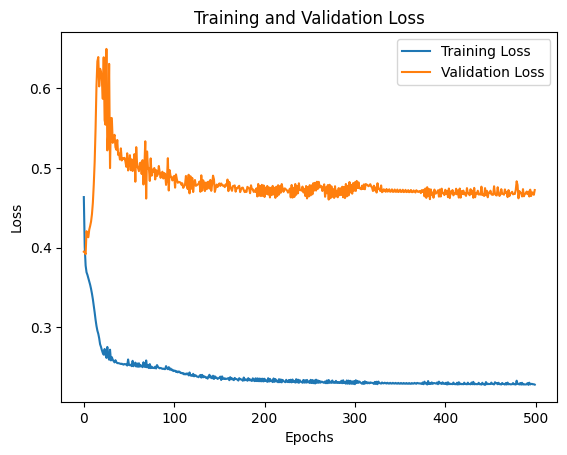

In [29]:
# plot losses
import matplotlib.pyplot as plt

_x = list(range(num_epoch))
plt.plot(_x, train_losses, label='Training Loss')
plt.plot(_x, val_losses, label='Validation Loss')
 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# # testing
# model.load_state_dict(torch.load('./best_checkpoint.pth'))
# model.eval()

# test_loss = 0
# for i, data in enumerate(tqdm(test_loader)):
#     data = data.to(device)
#     out = model(data)
#     loss = criterion(out, data.rgb)
#     test_loss += loss.item()
    
# print(f'Testing Loss: {test_loss / len(test_loader)}')

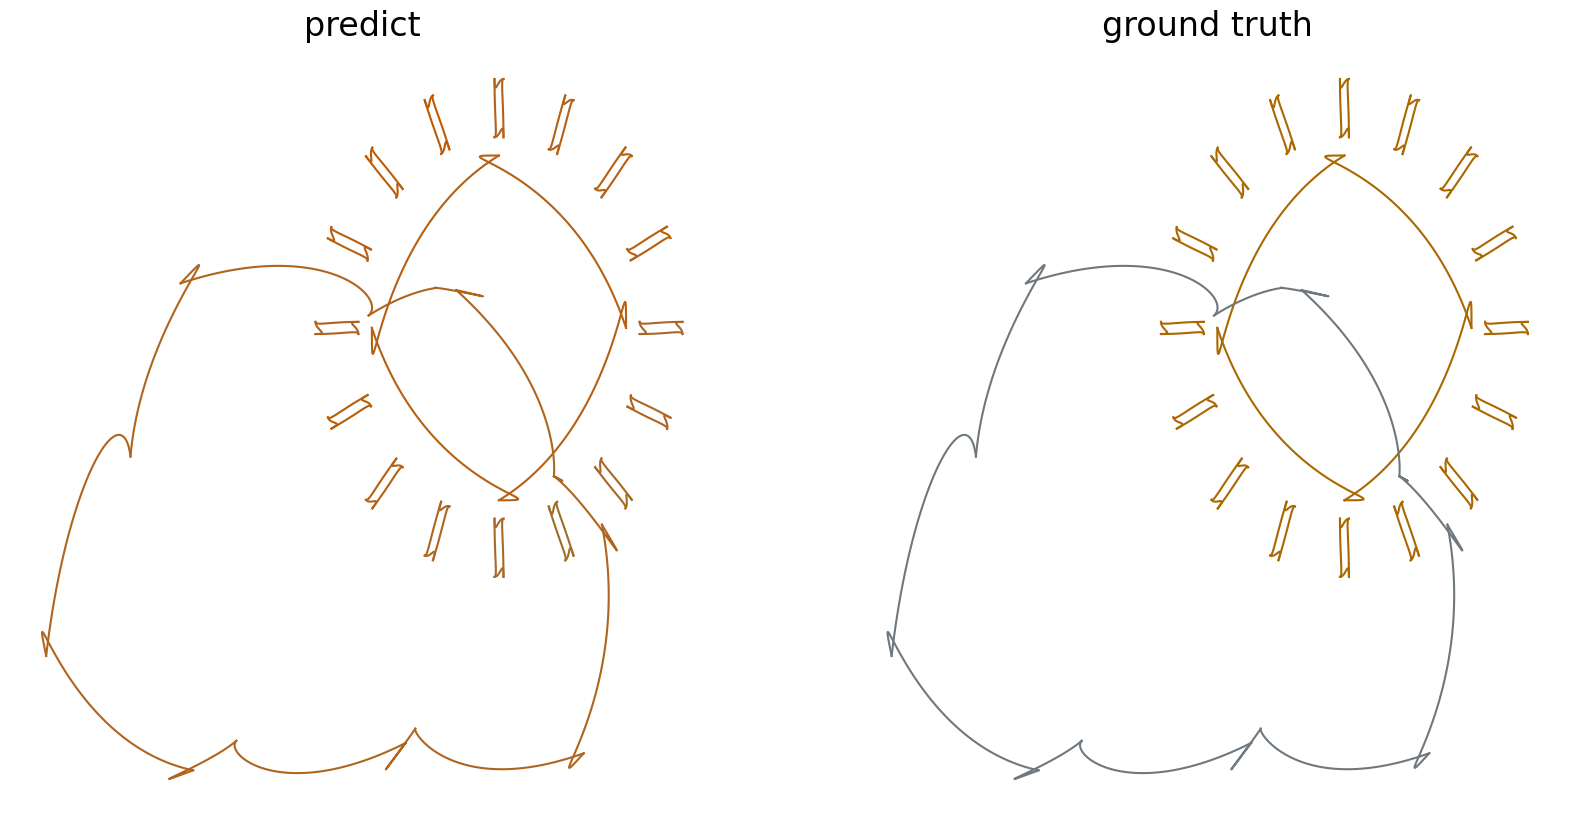

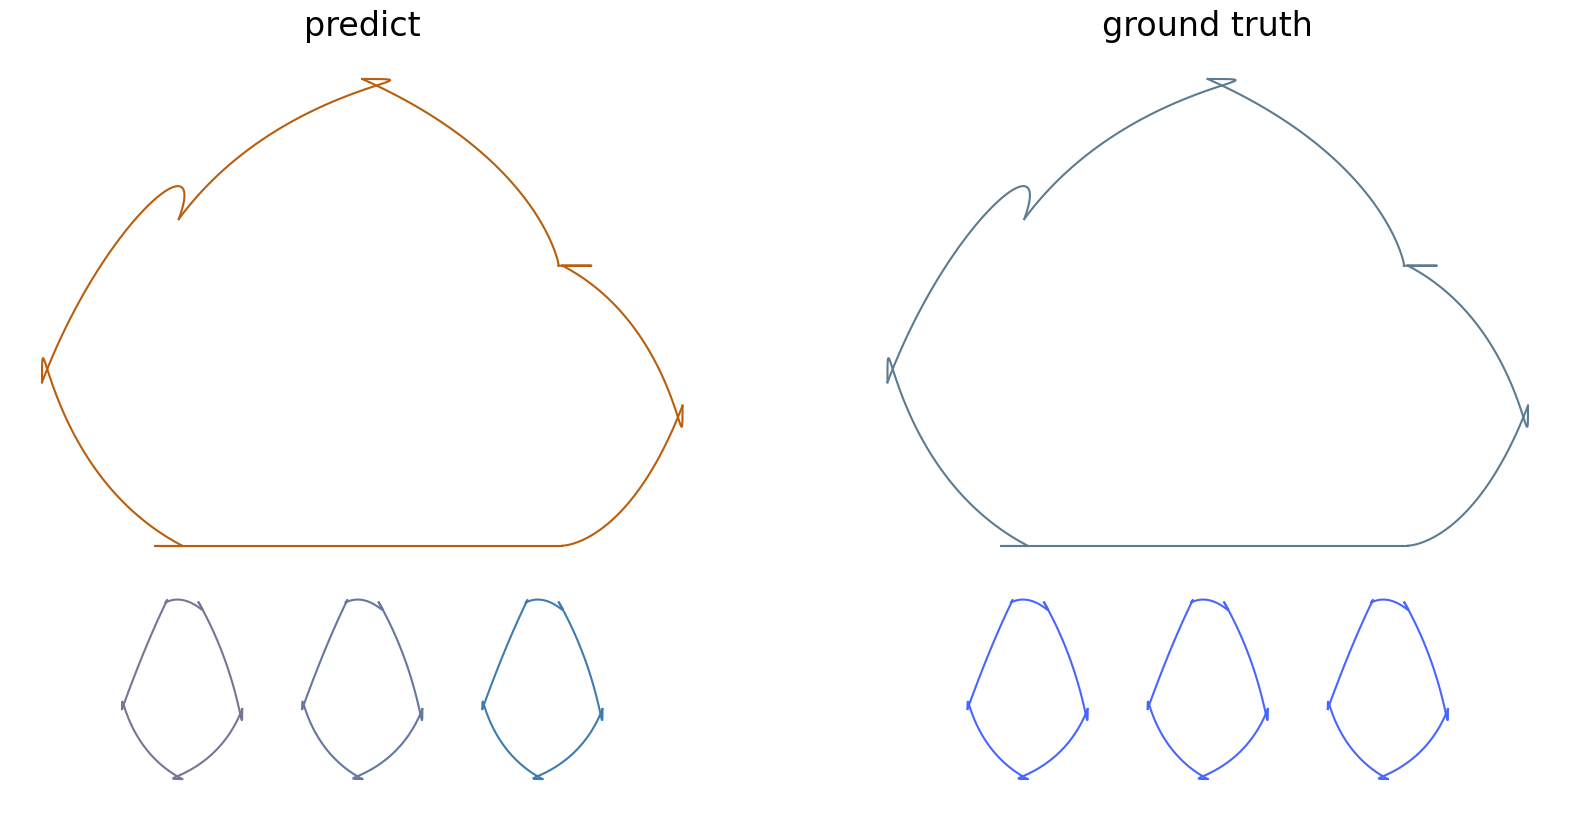

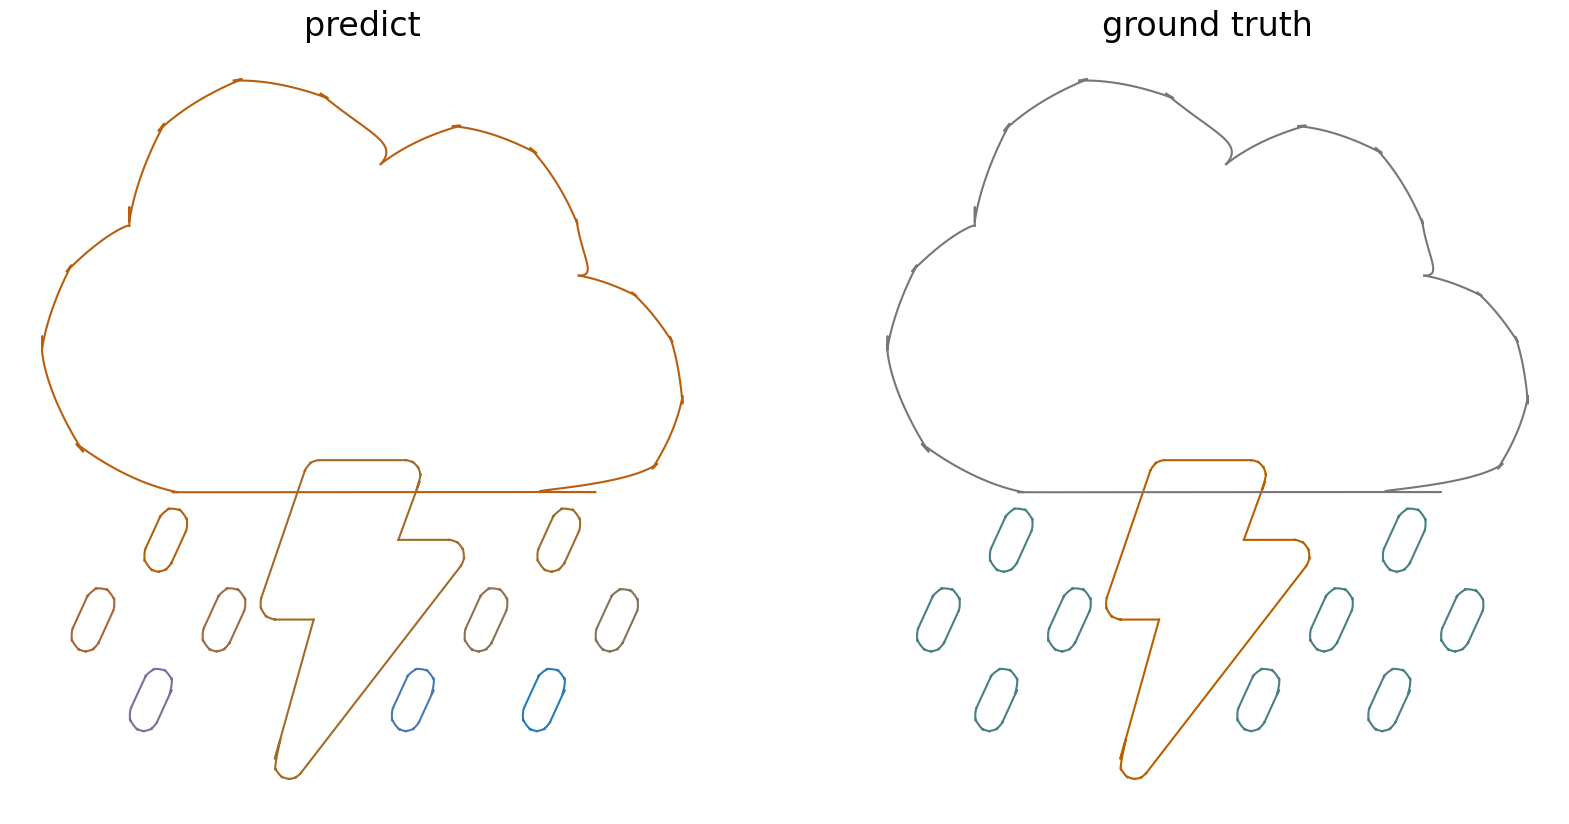

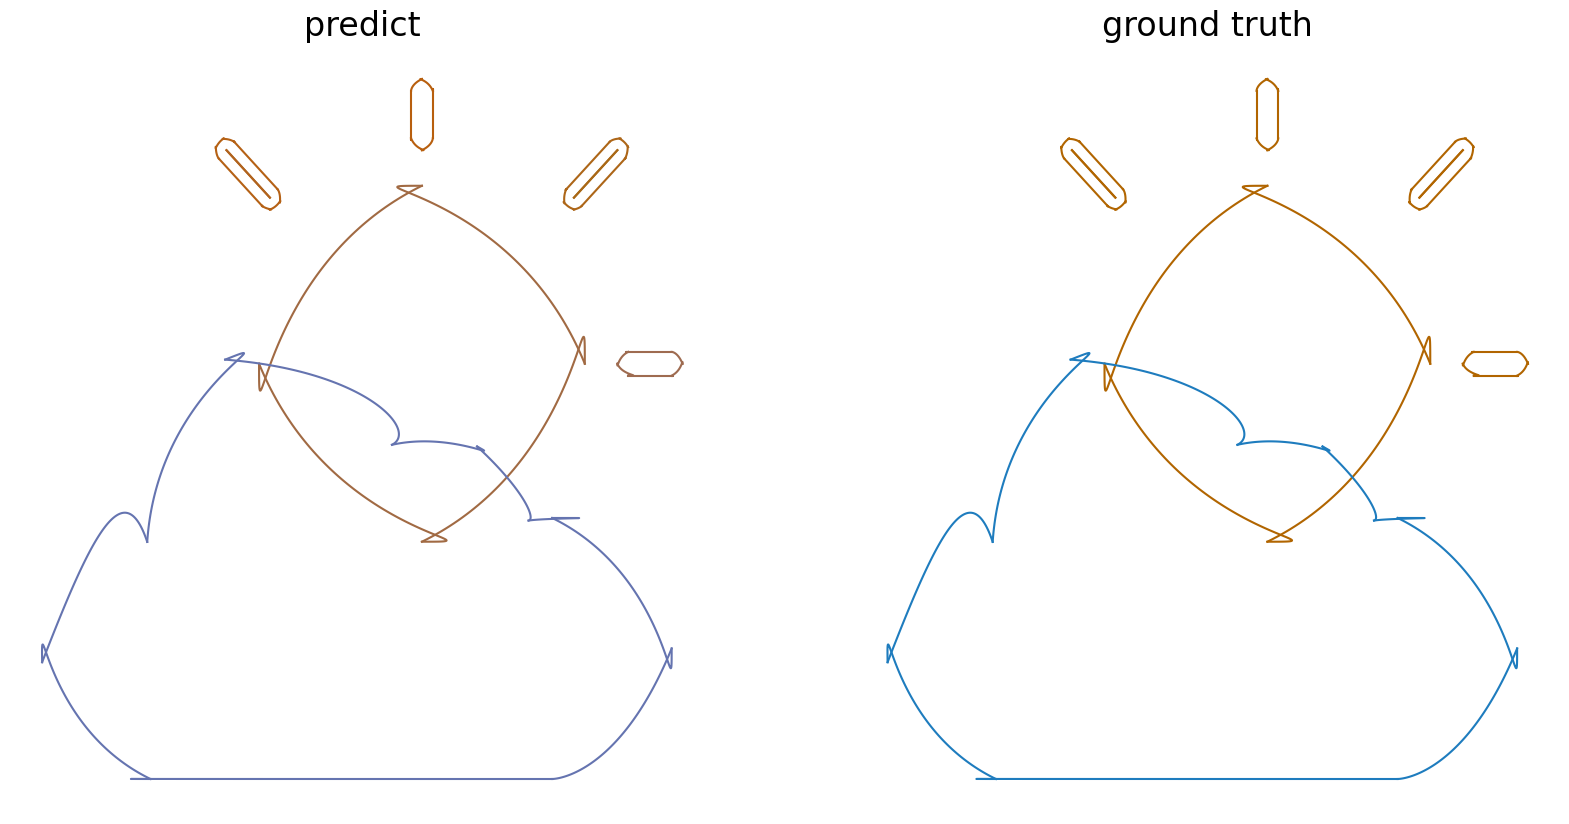

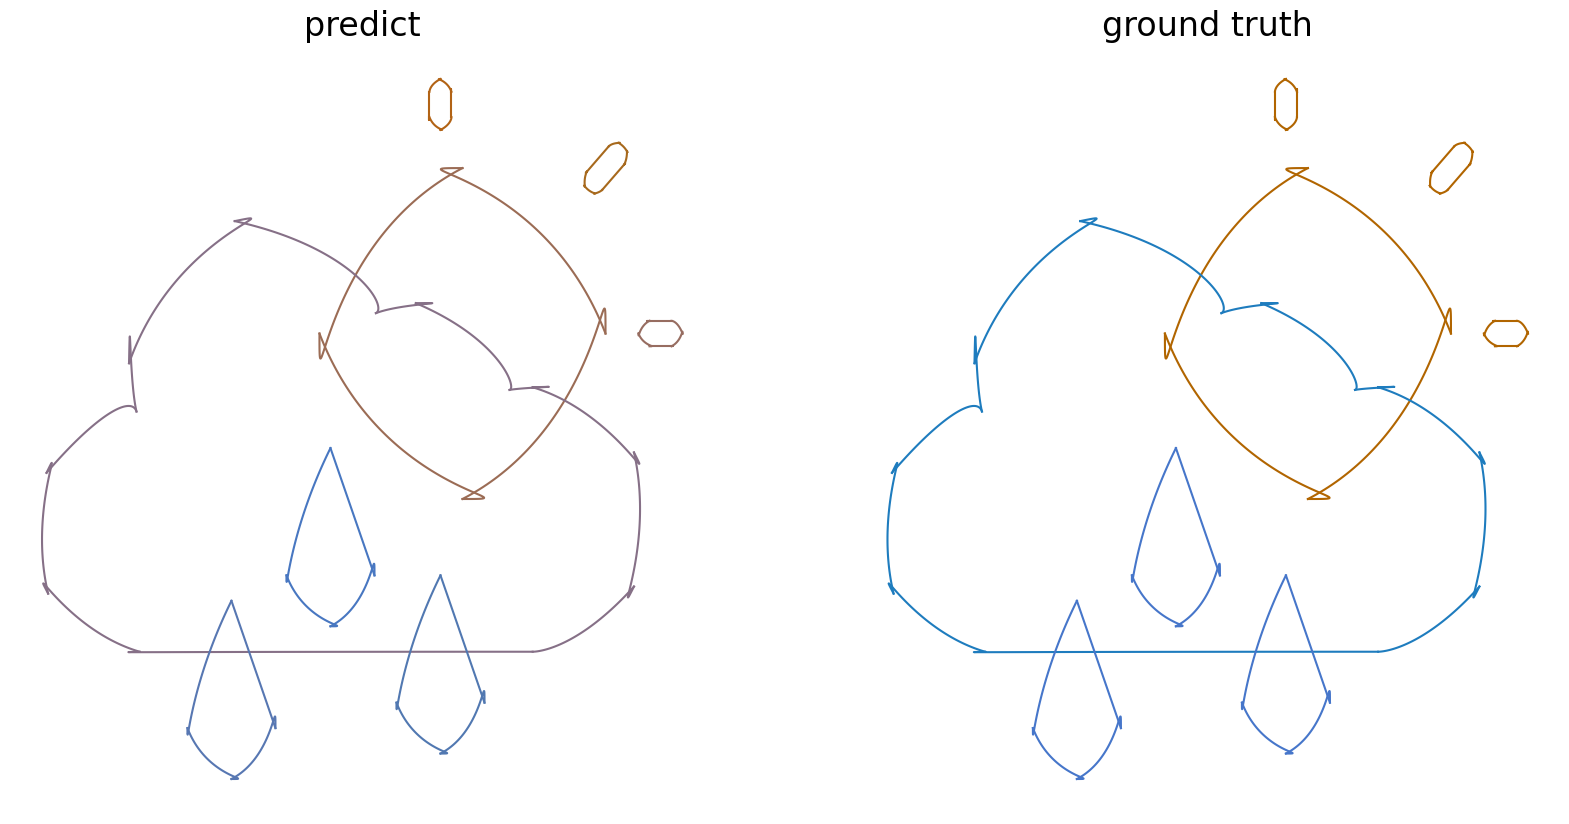

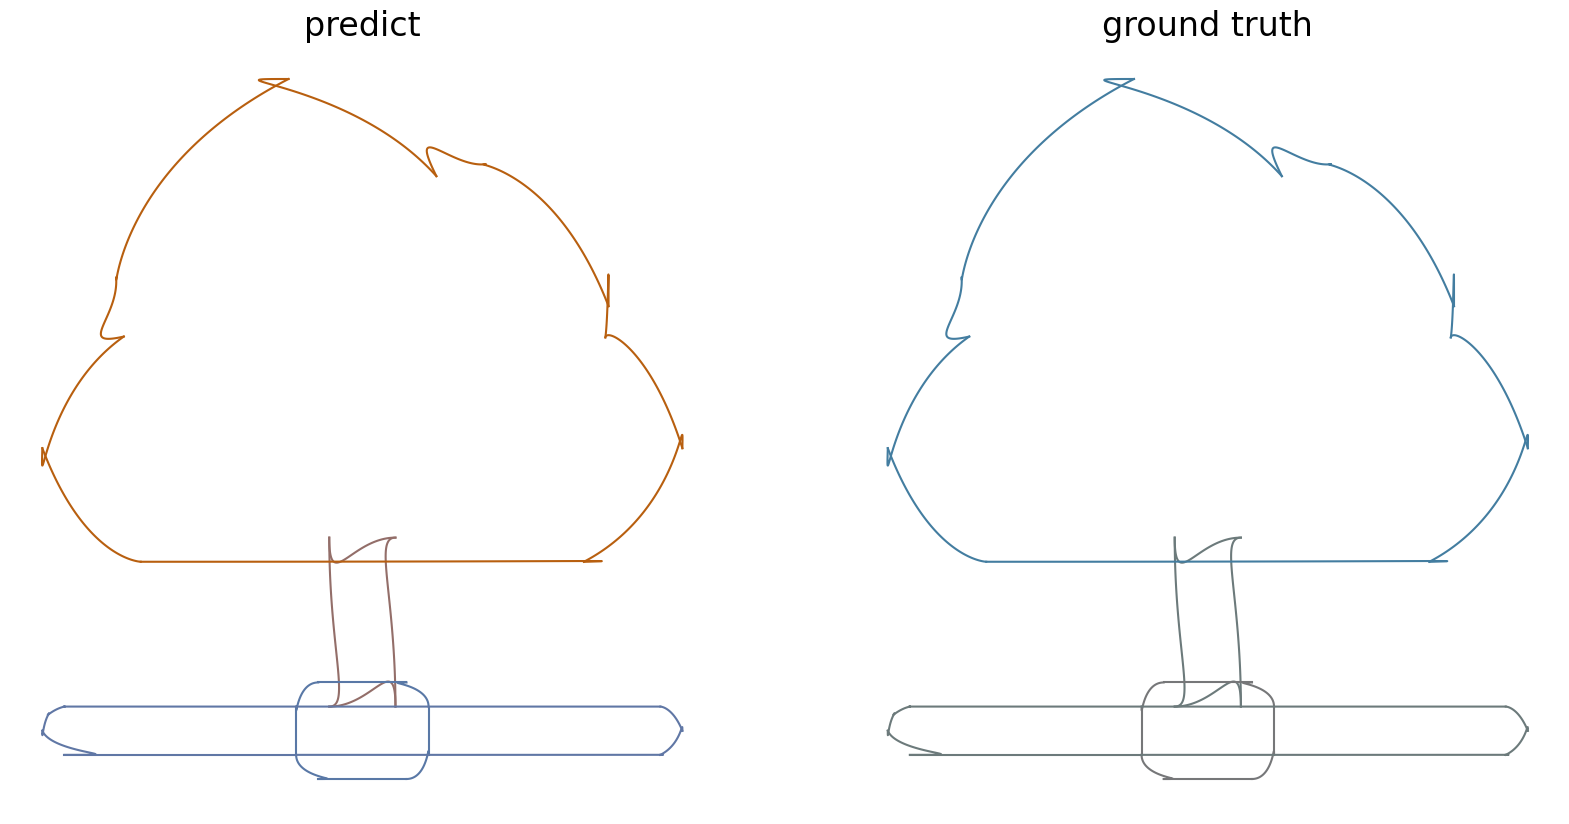

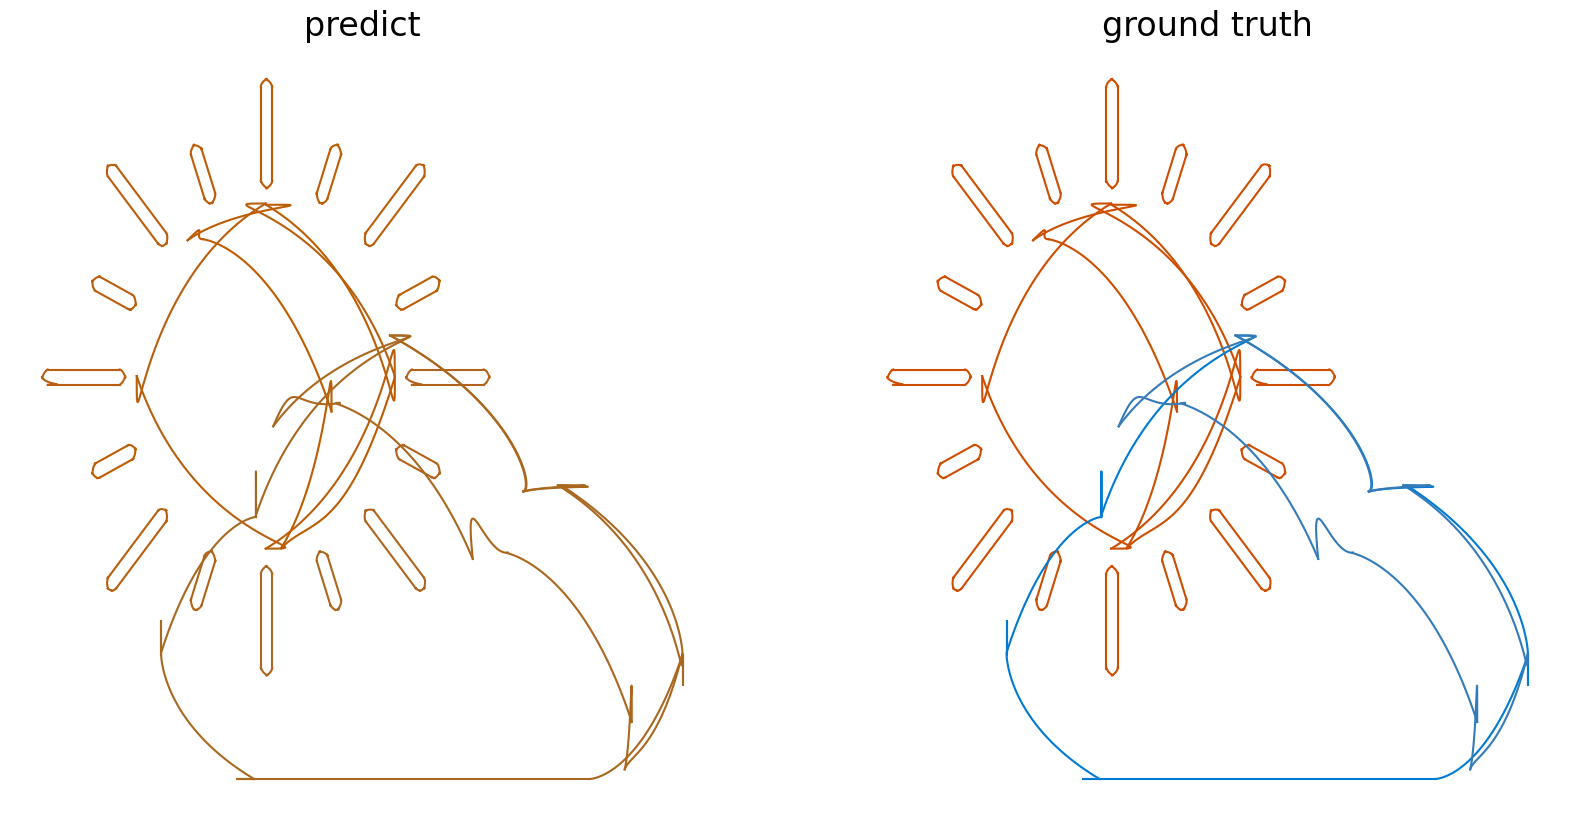

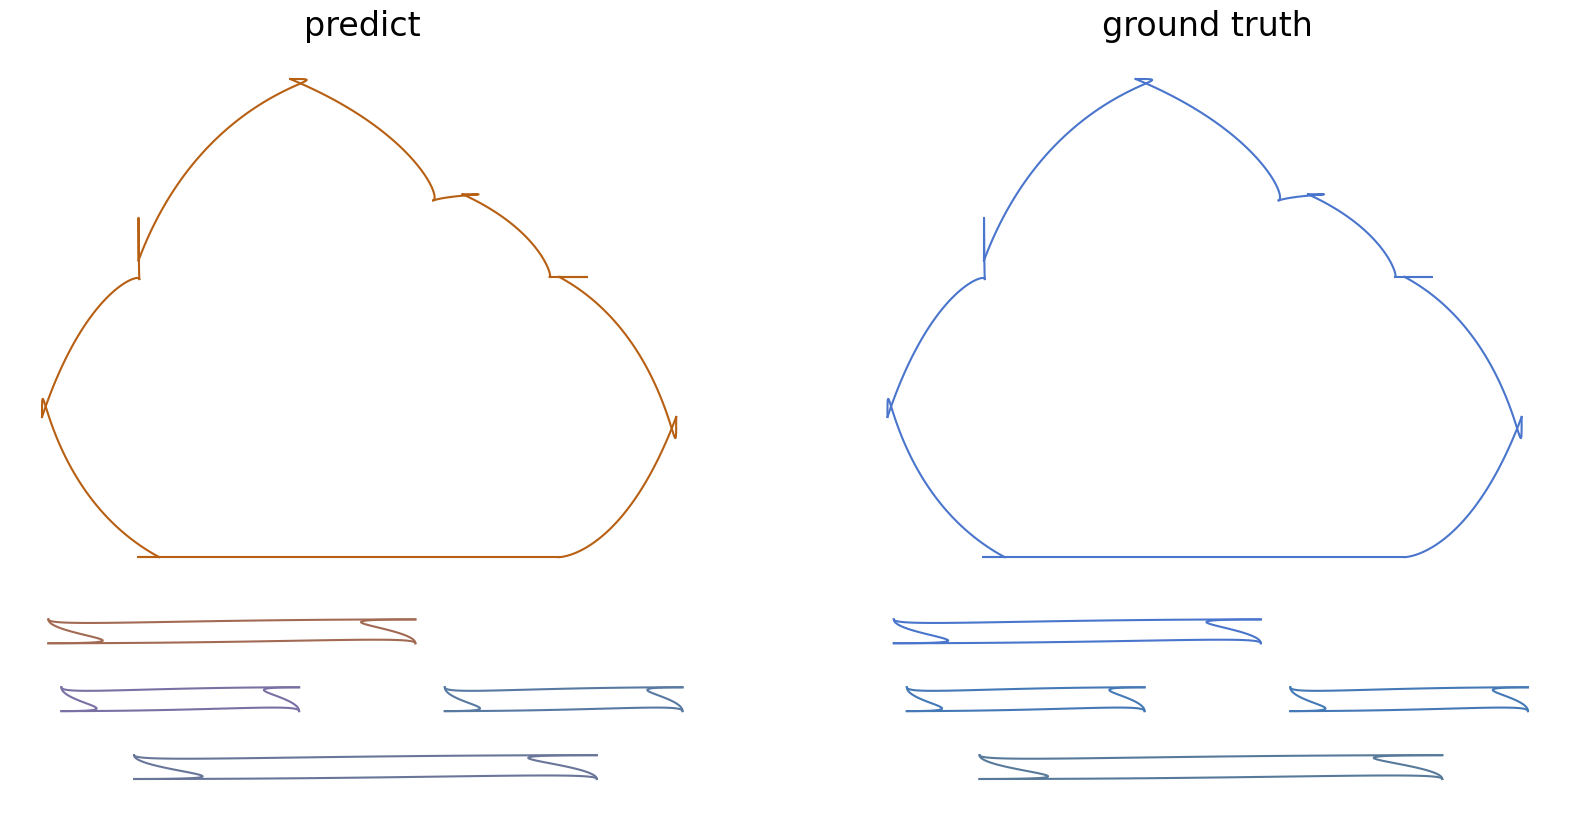

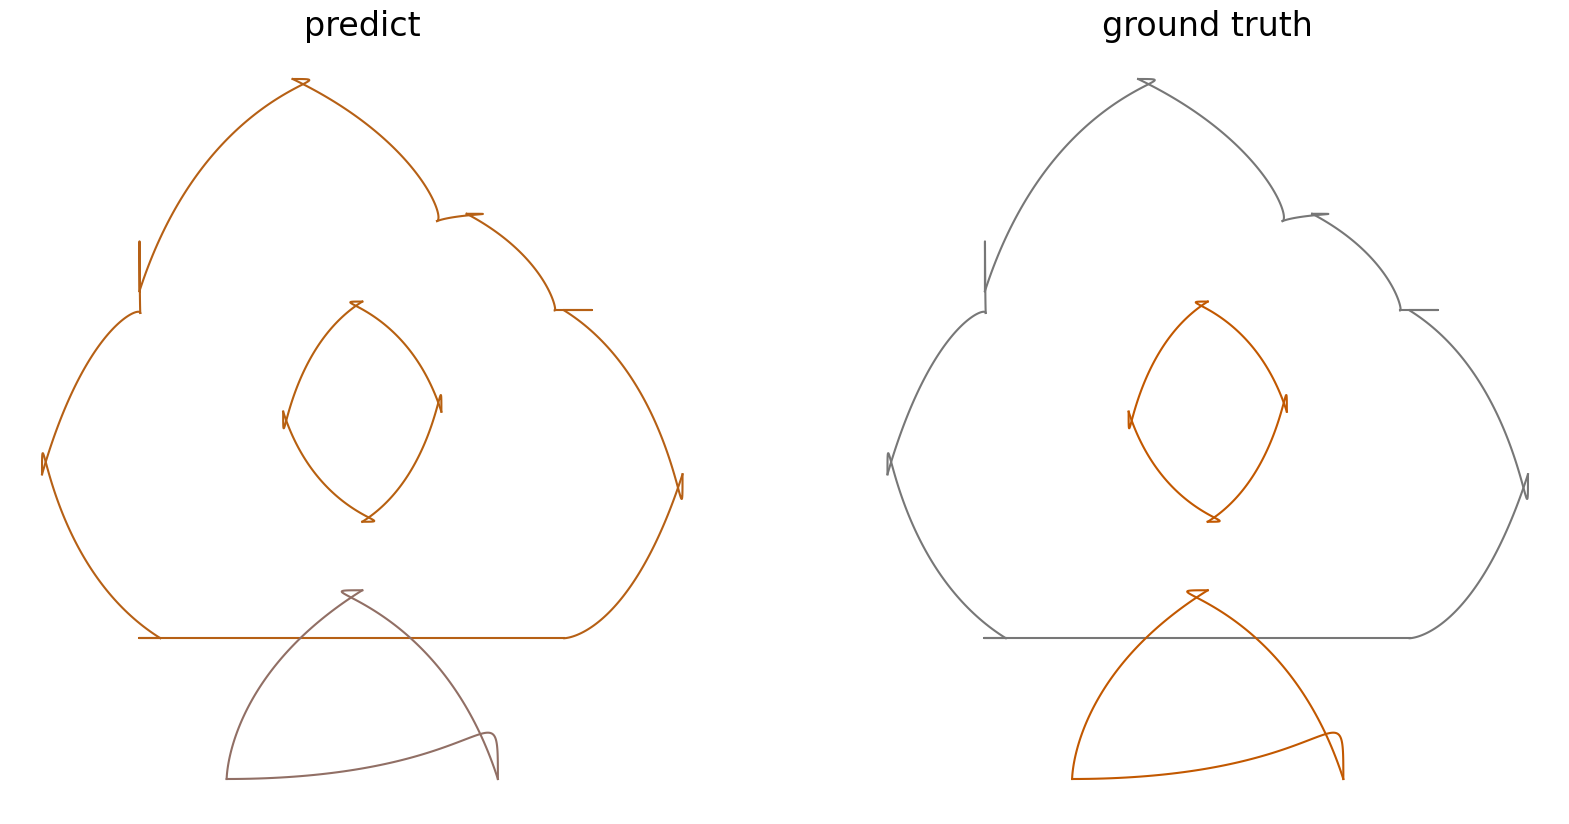

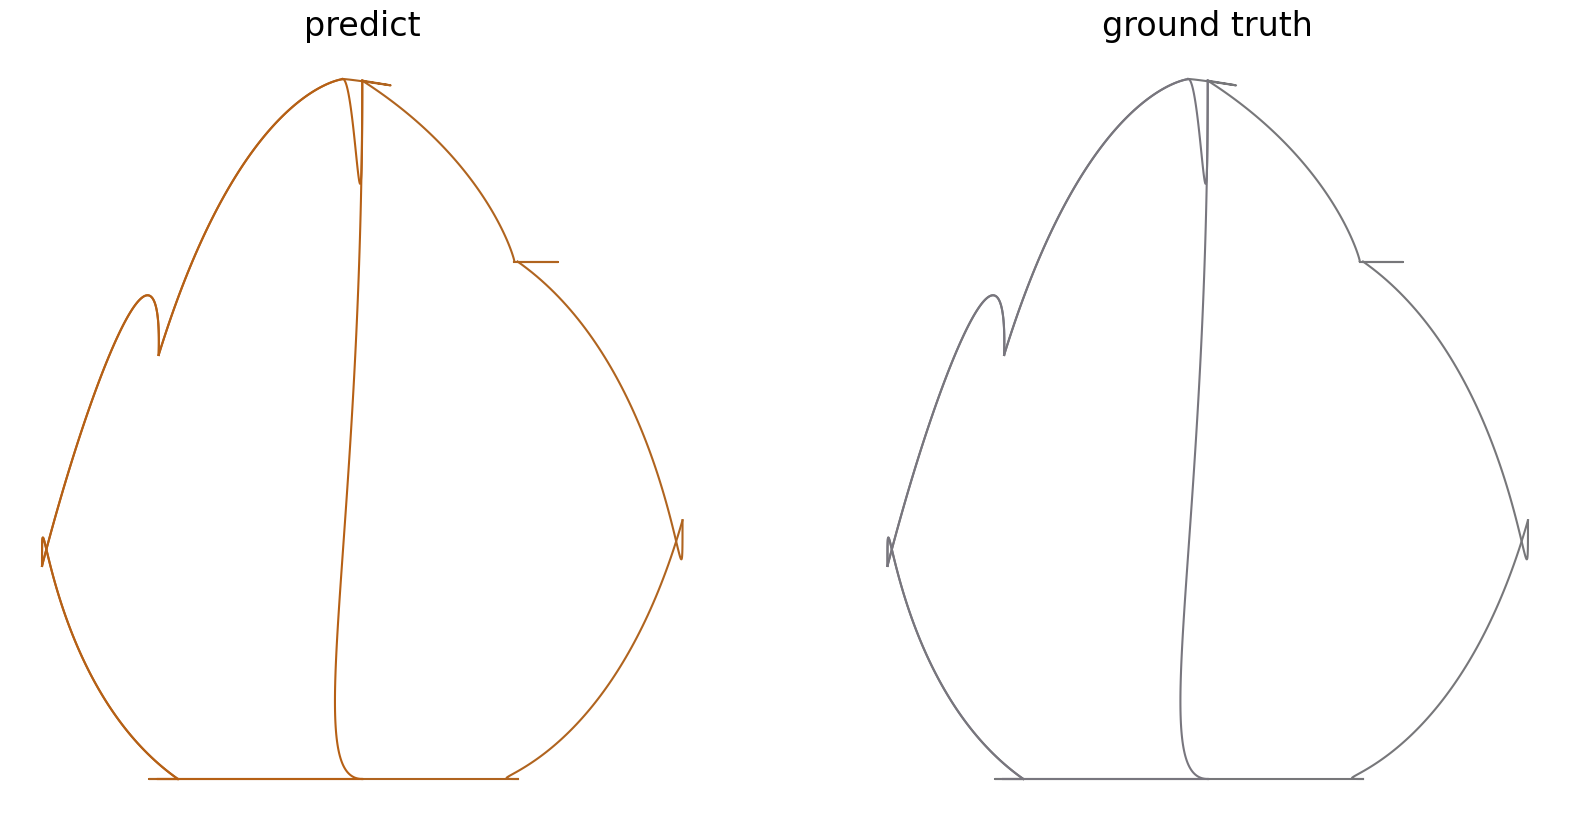

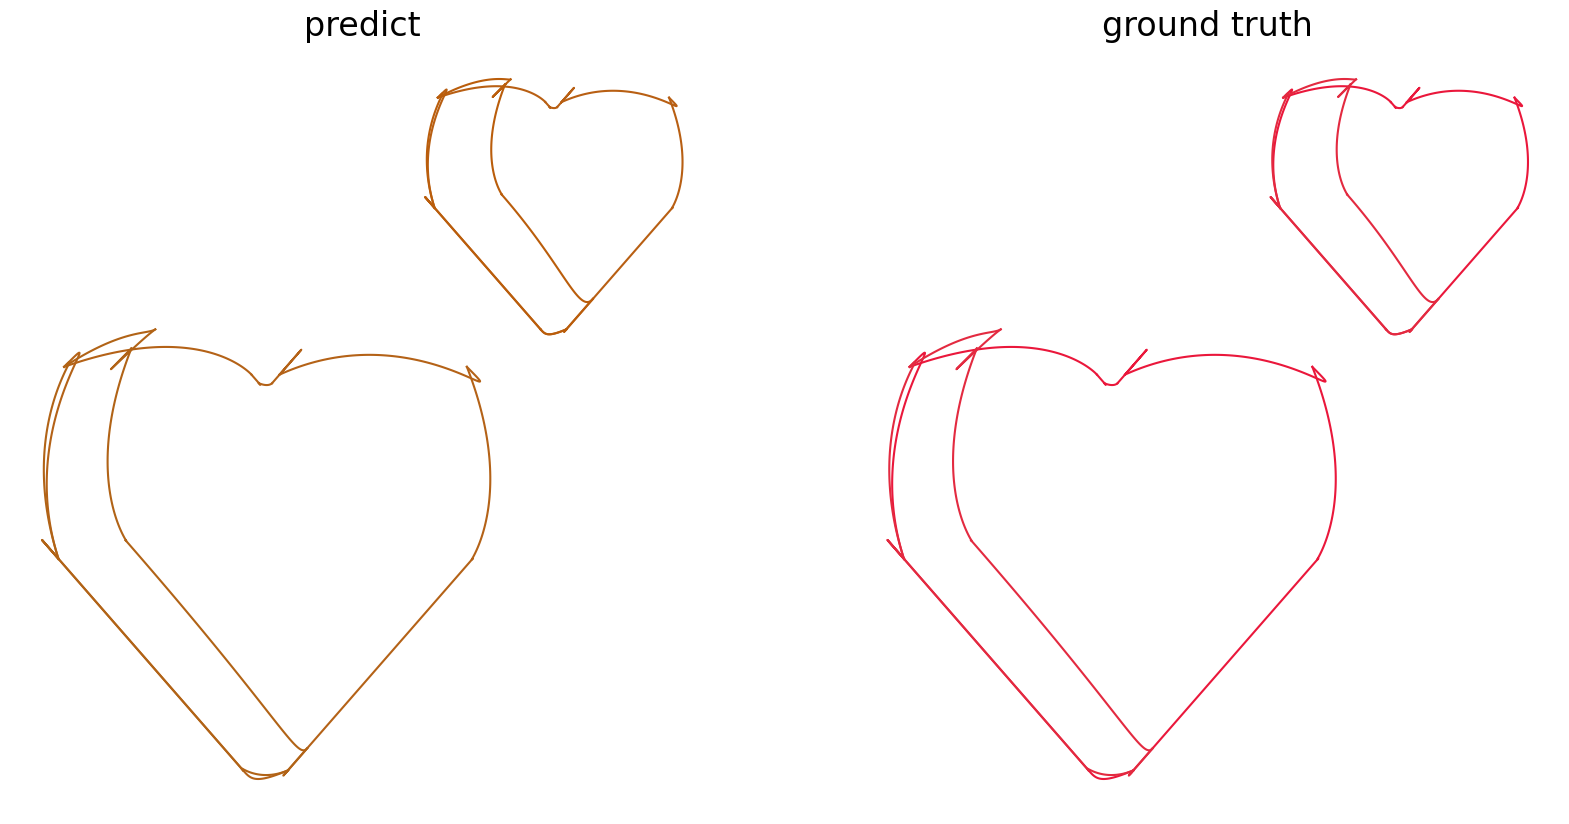

In [31]:
# visualize testing results
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from collections import OrderedDict
import colorsys
import skimage

# model.load_state_dict(torch.load('./debug_ckpt.pth'))
model.eval()

def bezier_curve(t, start, control1, control2, end):
    return (1 - t)**3 * start + 3 * (1 - t)**2 * t * control1 + 3 * (1 - t) * t**2 * control2 + t**3 * end

for data in train_loader:
    fig = plt.figure("plot", figsize=(20, 10))
    ax = fig.add_subplot(1, 2, 1)
    plt.axis("off")
    plt.title("predict", size=24)
    
    data = data.to(device)
    out = model(data)
    pos = data.x.cpu().detach().numpy()
    rgb = out[data.cluster].cpu().detach().numpy()    
    edge = np.transpose(data.edge_index.cpu().detach().numpy())
    clu = data.cluster.cpu().detach().numpy()
    control = data.edge_attr.cpu().detach().numpy()[:,:4]
    
    for i, ((n1, n2), (c1x, c1y, c2x, c2y)) in enumerate(zip(edge, control)):
        if n1 > n2: continue
        
        a, b = rgb[n1]
        a, b = float(a*256-128), float(b*256-128)
        r, g, b = skimage.color.lab2rgb([50, a, b])
        
        x1, y1 = pos[n1]
        x2, y2 = pos[n2]
        t = np.linspace(0, 1, num=100)
        x = [bezier_curve(j, x1, c1x, c2x, x2) for j in t]
        y = [bezier_curve(j, y1, c1y, c2y, y2) for j in t]
        plt.plot(x, y, color=[r, g, b])

        
    ax = fig.add_subplot(1, 2, 2)
    plt.axis("off")
    plt.title("ground truth", size=24)
    LAB = data.lab.cpu().detach().numpy()
    for i, ((n1, n2), (c1x, c1y, c2x, c2y)) in enumerate(zip(edge, control)):
        if n1 > n2: continue
        
        a, b = LAB[n1,1:]
        a, b = float(a*256-128), float(b*256-128)
        r, g, b = skimage.color.lab2rgb([50, a, b])
        
        x1, y1 = pos[n1]
        x2, y2 = pos[n2]
        t = np.linspace(0, 1, num=100)
        x = [bezier_curve(j, x1, c1x, c2x, x2) for j in t]
        y = [bezier_curve(j, y1, c1y, c2y, y2) for j in t]
        plt.plot(x, y, color=[r, g, b])
    
    plt.show()
    plt.close()
    # break

In [28]:
# # visualize testing results
# import matplotlib.pyplot as plt
# from matplotlib.lines import Line2D
# from collections import OrderedDict
# import colorsys
# import skimage

# # model.load_state_dict(torch.load('./debug_ckpt.pth'))
# model.eval()

# for data in train_loader:
    
#     fig = plt.figure("plot", figsize=(20, 10))
#     ax = fig.add_subplot(1, 2, 1)
#     plt.axis("off")
    
#     data = data.to(device)
#     out = model(data)
#     pos = data.x.cpu().detach().numpy()
#     rgb = out[data.cluster].cpu().detach().numpy()
    
#     # print(np.argmax(out.cpu().detach().numpy(), axis=1))  # for h classification
#     # rgb = out.cpu().detach().numpy()  # for predict each points w/o cluster
    
#     edge = np.transpose(data.edge_index.cpu().detach().numpy())
#     clu = data.cluster.cpu().detach().numpy()
    
#     # # for hsv
#     # for i, ((_, _, _, x, y), h) in enumerate(zip(pos, rgb)):
#     #     h = np.argmax(h) / 10
#     #     r, g, b = colorsys.hsv_to_rgb(h, 1, 1)
#     #     plt.scatter(x, y, color=[r, g, b], label=clu[i])
#     # for n1, n2 in edge:
#     #     x1, y1 = pos[n1, 3:]
#     #     x2, y2 = pos[n2, 3:]
#     #     h = np.argmax(rgb[n1]) / 10
#     #     color = colorsys.hsv_to_rgb(h, 1, 1)
#     #     l = Line2D([x1,x2], [y1,y2], alpha=0.5, color=color)
#     #     ax.add_line(l)

#     # # for rgb
#     # for i, ((_, _, _, x, y), (r, g, b)) in enumerate(zip(pos, rgb)):
#     #     plt.scatter(x, y, color=[r, g, b], label=clu[i])
#     # for n1, n2 in edge:
#     #     x1, y1 = pos[n1, 3:]
#     #     x2, y2 = pos[n2, 3:]
#     #     l = Line2D([x1,x2], [y1,y2], alpha=0.5, color=rgb[n1])
#     #     ax.add_line(l)

#     # for lab
#     for i, ((_, _, _, x, y), (a, b)) in enumerate(zip(pos, rgb)):
#         a, b = float(a*256-128), float(b*256-128)
#         r, g, b = skimage.color.lab2rgb([50, a, b])
#         plt.scatter(x, y, color=[r, g, b], label=clu[i])
#     for n1, n2 in edge:
#         x1, y1 = pos[n1, 3:]
#         x2, y2 = pos[n2, 3:]
#         a, b = rgb[n1] * 256 - 128
#         color = skimage.color.lab2rgb([50, a, b])
#         l = Line2D([x1,x2], [y1,y2], alpha=0.5, color=color)
#         ax.add_line(l)
        
#     handles, labels = plt.gca().get_legend_handles_labels()
#     by_label = OrderedDict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys(), loc="lower right")
#     plt.title("predict", size=24)
        
#     ax = fig.add_subplot(1, 2, 2)
#     plt.axis("off")
#     plt.title("ground truth", size=24)
#     RGB = data.rgb.cpu().detach().numpy()
#     HSV = data.hsv.cpu().detach().numpy()
#     LAB = data.lab.cpu().detach().numpy()
#     for i, ((_, _, _, x, y), (r, g, b), (h, s, v), (l, a, bb)) in enumerate(zip(pos, RGB, HSV, LAB)):
#         label = f"{clu[i]} {(r, g, b)}"
#         # label = f"{clu[i]} {(h, s, v)}"
#         a, b = float(a*256-128), float(bb*256-128)
#         r, g, b = skimage.color.lab2rgb([50, a, b])
#         plt.scatter(x, y, color=[r, g, b], label=label)
#     for n1, n2 in edge:
#         x1, y1 = pos[n1, 3:]
#         x2, y2 = pos[n2, 3:]
#         a, b = LAB[n1, 1:] * 256 - 128
#         color = skimage.color.lab2rgb([50, a, b])
#         l = Line2D([x1,x2], [y1,y2], alpha=0.5, color=color)  # RGB[n1]
#         ax.add_line(l)
#     handles, labels = plt.gca().get_legend_handles_labels()
#     by_label = OrderedDict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys(), loc="lower right")
    
#     plt.show()
#     plt.close()
#     # break

---
---
## CNN
(but not work)

In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(64*16*16, 1024)
#         self.fc2 = nn.Linear(1024, 64*64*3)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x)
#         x = F.relu(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))
#         x = x.view(-1, 3, 64, 64)
#         return x

In [20]:
# train_losses = []
# val_losses = []
# best_loss = float('inf')
# num_epoch = 1000

# for epoch in range(num_epoch):  # num_epoch
#     train_loss = 0
#     val_loss = 0
#     train_err = 0
#     val_err = 0
    
#     model.train()
#     for data in train_loader:
#         if data.x.shape[0] == 0:
#             train_err += 1
#             continue
        
#         x = copy.deepcopy(data.x)[:,3:]
#         x = np.interp(x, (x.min(), x.max()), (0, 63))
#         x = np.rint(x).astype(int)
#         img = np.zeros((64, 64, 1), dtype=np.float32)
#         num_cls = data.cluster[-1] + 1
#         target = np.zeros((num_cls, 3), dtype=np.float32)
#         # target = np.zeros((64, 64, 3), dtype=np.float32)
#         mask = np.zeros((64*64), dtype=np.float32)
#         for i, ((xx, yy), rgb, cls) in enumerate(zip(x, data.rgb, data.cluster)):
#             img[xx, yy, :] = 1
#             # target[xx, yy] = rgb.numpy().tolist()
#             target[cls] = rgb.numpy().tolist()
#             mask[i] = int(cls) + 1
            
#         img = np.expand_dims(img, axis=0)
#         img = np.transpose(img, (0, 3, 1, 2))
#         img = torch.tensor(img).type(torch.float).to(device)
#         target = torch.tensor(target).type(torch.float).to(device)
#         mask = np.array(mask)
        
#         optimizer.zero_grad()    
#         out = model(img)
#         # out = out.permute(0, 2, 3, 1).squeeze(0)
        
#         out_flat = out.view(-1, 3)
#         res = torch.zeros(num_cls, 3)
#         cnt = torch.zeros(num_cls)
#         for i in range(num_cls):
#             values = out_flat[mask==i+1]
#             if values.shape[0] > 0:
#                 res[i] = torch.mean(values, dim=0)
#                 cnt[i] = values.shape[0]
#         res = res / cnt[:, None]
#         res = res.view(num_cls, 3).to(device)    
        
#         loss = criterion(res, target)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
        
#     model.eval()
#     for data in val_loader:
#         if data.x.shape[0] == 0:
#             val_err += 1
#             continue
        
#         x = copy.deepcopy(data.x)[:,3:]
#         x = np.interp(x, (x.min(), x.max()), (0, 63))
#         x = np.rint(x).astype(int)
#         img = np.zeros((64, 64, 1), dtype=np.float32)
#         num_cls = data.cluster[-1] + 1
#         target = np.zeros((num_cls, 3), dtype=np.float32)
#         # target = np.zeros((64, 64, 3), dtype=np.float32)
#         mask = np.zeros((64*64), dtype=np.float32)
#         for i, ((xx, yy), rgb, cls) in enumerate(zip(x, data.rgb, data.cluster)):
#             img[xx, yy, :] = 1
#             # target[xx, yy] = rgb.numpy().tolist()
#             target[cls] = rgb.numpy().tolist()
#             mask[i] = int(cls) + 1
            
#         img = np.expand_dims(img, axis=0)
#         img = np.transpose(img, (0, 3, 1, 2))
#         img = torch.tensor(img).type(torch.float).to(device)
#         target = torch.tensor(target).type(torch.float).to(device)
#         mask = np.array(mask)
           
#         out = model(img)
#         # out = out.permute(0, 2, 3, 1).squeeze(0)
        
#         out_flat = out.view(-1, 3)
#         res = torch.zeros(num_cls, 3)
#         cnt = torch.zeros(num_cls)
#         for i in range(num_cls):
#             values = out_flat[mask==i+1]
#             if values.shape[0] > 0:
#                 res[i] = torch.mean(values, dim=0)
#                 cnt[i] = values.shape[0]
#         res = res / cnt[:, None]
#         res = res.view(num_cls, 3).to(device)    
        
#         loss = criterion(res, target)
#         val_loss += loss.item()
    
#     train_avg = train_loss / (len(train_loader)-train_err)
#     val_avg = val_loss / (len(val_loader)-val_err)
#     train_losses.append(train_avg)
#     val_losses.append(val_avg)
    
#     print(f'Epoch {epoch}\tTraining Loss: {train_avg}\tValidation Loss: {val_avg}')
    
#     if val_avg < best_loss:
#         print(f'Validation Loss Decreased({best_loss:.6f}--->{val_avg:.6f})\tSaving The Model')
#         best_loss = val_avg

In [21]:
# # visualize testing results
# import matplotlib.pyplot as plt

# model.eval()
# for data in val_loader:
    
#     fig = plt.figure("plot", figsize=(20, 10))
#     ax = fig.add_subplot(1, 2, 1)
#     plt.axis("off")
    
#     x = copy.deepcopy(data.x)[:,3:]
#     x = np.interp(x, (x.min(), x.max()), (0, 63))
#     x = np.rint(x).astype(int)
#     img = np.zeros((64, 64, 1), dtype=np.float32)
#     num_cls = data.cluster[-1] + 1
#     target = np.zeros((num_cls, 3), dtype=np.float32)
#     # target = np.zeros((64, 64, 3), dtype=np.float32)
#     mask = np.zeros((64, 64), dtype=np.float32)
#     for (xx, yy), rgb, cls in zip(x, data.rgb, data.cluster):
#         img[xx, yy, :] = 1
#         # target[xx, yy] = rgb.numpy().tolist()
#         target[cls] = rgb.numpy().tolist()
#         mask[xx, yy] = int(cls) + 1
        
#     temp_img = copy.deepcopy(img)
#     temp_tar = copy.deepcopy(target)
#     img = np.expand_dims(img, axis=0)
#     img = np.transpose(img, (0, 3, 1, 2))
#     img = torch.tensor(img).type(torch.float).to(device)
#     target = torch.tensor(target).type(torch.float).to(device)
#     mask = np.array(mask)
        
#     out = model(img)    
#     out_flat = out.view(-1, 3)
#     mask_flat = torch.tensor(mask).view(-1)
#     res = torch.zeros(num_cls, 3)
#     cnt = torch.zeros(num_cls)
#     for i in range(num_cls):
#         values = out_flat[mask_flat==i+1]
#         if values.shape[0] > 0:
#             res[i] = torch.mean(values, dim=0)
#             cnt[i] = values.shape[0]
#     res = res / cnt[:, None]
#     res = res.view(num_cls, 3).detach().numpy()
    
    
#     for i in range(temp_img.shape[0]):
#         for j in range(temp_img.shape[1]):
#             if temp_img[i][j] != 0:
#                 plt.scatter(i, j, color=res[int(mask[i][j])-1], edgecolors='black', s=50)
#     plt.title("predict", size=24)
        
#     ax = fig.add_subplot(1, 2, 2)
#     plt.axis("off")
#     plt.title("ground truth", size=24)
#     for i in range(temp_img.shape[0]):
#         for j in range(temp_img.shape[1]):
#             if temp_img[i][j] != 0:
#                 plt.scatter(i, j, color=temp_tar[int(mask[i][j])-1], edgecolors='black', s=50)
    
#     plt.show()
#     plt.close()
#     # break